In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.gaussian_process as gp
from scipy.integrate import solve_ivp
import scipy.linalg as la
from scipy.stats import gaussian_kde
from sur_data import rw_metropolis_hastings
from scipy.io import loadmat
import gp_regression as gpr

In [3]:
%matplotlib notebook
plt.style.use('seaborn')

In [4]:
def lotka_volterra(t,y,a,b,c,d):
    dy = np.empty_like(y)
    # switched to match
    dy[0] = d*y[0]*y[1]-c*y[0] # predator
    dy[1] = a*y[1]-b*y[0]*y[1] # prey
    return dy

def solve_lv(T,y0,a,b,c,d):
    sol = solve_ivp(lotka_volterra,(T[0],T[-1]),y0,t_eval=T,args=(a,b,c,d))
    return sol.y

In [80]:
# load matlab data
y_noisy = loadmat('y.mat')['tmp'].T
hp1 = loadmat('hp1.mat')['hp1'][0]
hp1 = {'tau2':hp1[0],'l2':hp1[2],'sigma2':hp1[1]}
hp2 = loadmat('hp2.mat')['hp2'][0]
hp2 = {'tau2':hp2[0],'l2':hp2[2],'sigma2':hp2[1]}
W1_mat = loadmat('W1.mat')['tmp1']
W2_mat = loadmat('W2.mat')['tmp2']
Sigma1_mat = loadmat('Sigma1.mat')['tmp3']
Sigma2_mat = loadmat('Sigma2.mat')['tmp4']
V1 = loadmat('eig1.mat')['V1']
D1 = loadmat('eig1.mat')['D1']
V2 = loadmat('eig2.mat')['V2']
D2 = loadmat('eig2.mat')['D2']

T_obs = np.linspace(0,10,10)

## Test if sklearn finds same hyperparameters

In [23]:
kernel1 = gp.kernels.ConstantKernel()*gp.kernels.RBF()+gp.kernels.WhiteKernel()
kernel2 = gp.kernels.ConstantKernel()*gp.kernels.RBF()+gp.kernels.WhiteKernel()
y1_gp = gp.GaussianProcessRegressor(kernel1)
y1_gp = y1_gp.fit(T_obs[:,np.newaxis],y_noisy[0].T)
y2_gp = gp.GaussianProcessRegressor(kernel2)
y2_gp = y2_gp.fit(T_obs[:,np.newaxis],y_noisy[1].T)

/Users/hringer/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [24]:
y1_gp.kernel_, hp1

(1.21**2 * RBF(length_scale=1.52) + WhiteKernel(noise_level=1e-05),
 {'tau2': 0.4786452454223726,
  'l2': 2.875407155249297,
  'sigma2': 0.08993485262629758})

In [25]:
y2_gp.kernel_, hp2

(0.924**2 * RBF(length_scale=1.63) + WhiteKernel(noise_level=0.0475),
 {'tau2': 0.4021615204713249,
  'l2': 2.2375422149309916,
  'sigma2': 0.05675103073650805})

It does not!

## Check how covariance matrices differ

In [35]:
# define high-res time points for evaluation
T_sur = np.linspace(0,10,201)

# compute mean and covariance of GPs
mean1,cov1_gp = y1_gp.predict(T_sur[:,np.newaxis],return_cov=True)
mean2,cov2_gp = y2_gp.predict(T_sur[:,np.newaxis],return_cov=True)

#symmytrize
cov1_gp = .5*(cov1_gp+cov1_gp.T)
cov2_gp = .5*(cov2_gp+cov2_gp.T)

# compute eigendecompositions
e1,v1 = la.eig(cov1_gp)
e2,v2 = la.eig(cov2_gp)

# build weight matrices
W1 = np.real(np.diag(np.sqrt(1/e1))@(v1.T))
W2 = np.real(np.diag(np.sqrt(1/e2))@(v2.T))

In [40]:
la.norm(W1-W1_mat),la.norm(W2-W2_mat)

(4322.553340278597, 86.13275572179298)

Very large difference in norm

<IPython.core.display.Javascript object>


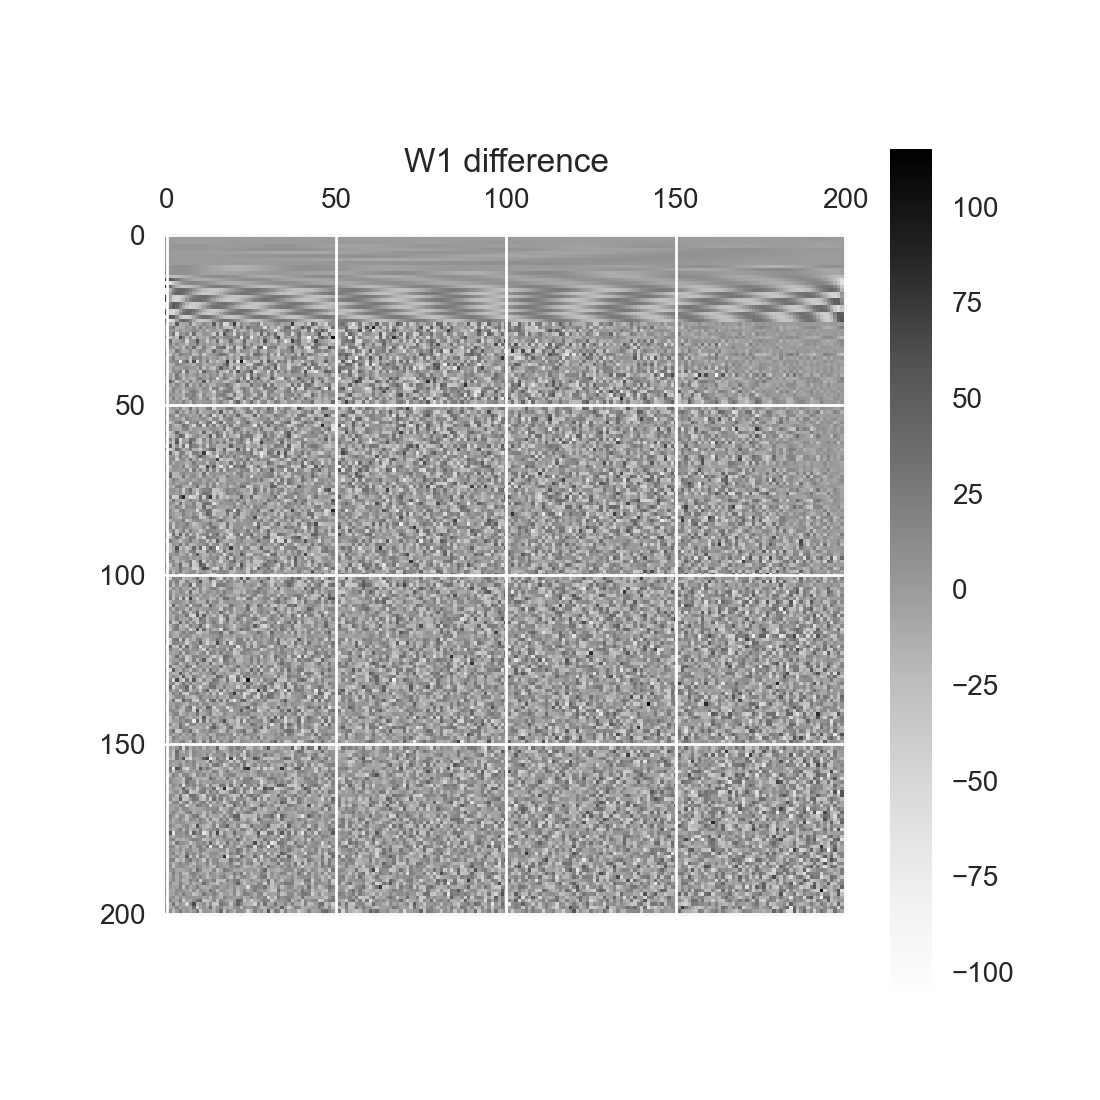

<IPython.core.display.Javascript object>


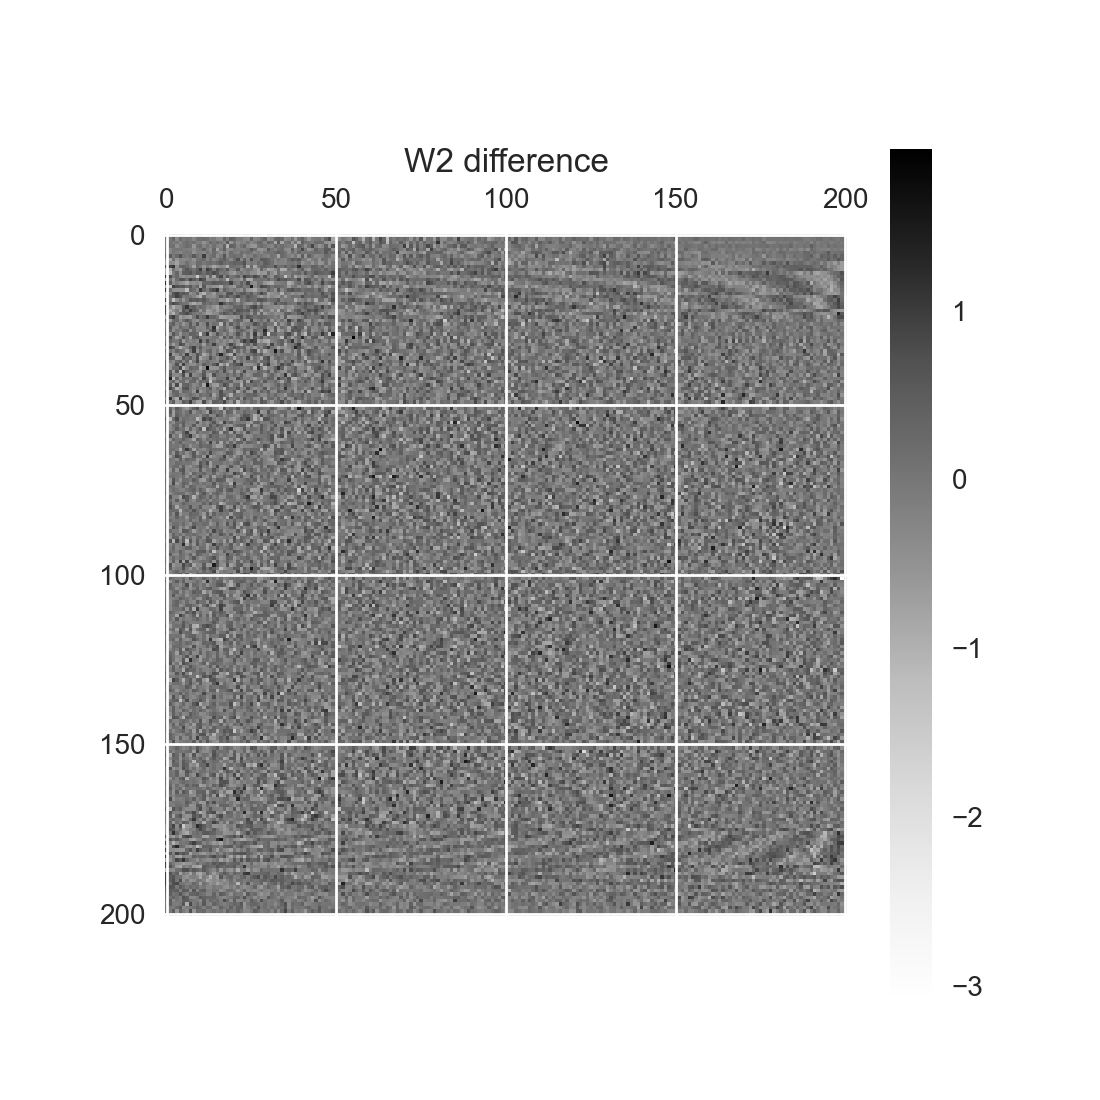

In [42]:
# check for structure
plt.matshow(W1-W1_mat)
plt.colorbar()
plt.title('W1 difference')
plt.show()
plt.matshow(W2-W2_mat)
plt.colorbar()
plt.title('W2 difference')
plt.show()

# Force same hyperparameters

In [121]:
kernel1 = gp.kernels.ConstantKernel(hp1['tau2'],constant_value_bounds='fixed') \
         *gp.kernels.RBF(hp1['l2']**.5,length_scale_bounds='fixed') \
         +gp.kernels.WhiteKernel(hp1['sigma2'],noise_level_bounds='fixed')
kernel2 = gp.kernels.ConstantKernel(hp2['tau2'],constant_value_bounds='fixed') \
         *gp.kernels.RBF(hp2['l2']**.5,length_scale_bounds='fixed') \
         +gp.kernels.WhiteKernel(hp2['sigma2'],noise_level_bounds='fixed')
y1_gp = gp.GaussianProcessRegressor(kernel1,alpha=np.finfo('float64').eps**0.5)
y1_gp = y1_gp.fit(T_obs[:,np.newaxis],y_noisy[0].T)
y2_gp = gp.GaussianProcessRegressor(kernel2,alpha=np.finfo('float64').eps**0.5)
y2_gp = y2_gp.fit(T_obs[:,np.newaxis],y_noisy[1].T)

In [122]:
print(y1_gp.kernel_, hp1)
print(y2_gp.kernel_, hp2)

0.692**2 * RBF(length_scale=1.7) + WhiteKernel(noise_level=0.0899) {'tau2': 0.4786452454223726, 'l2': 2.875407155249297, 'sigma2': 0.08993485262629758}
0.634**2 * RBF(length_scale=1.5) + WhiteKernel(noise_level=0.0568) {'tau2': 0.4021615204713249, 'l2': 2.2375422149309916, 'sigma2': 0.05675103073650805}


In [123]:
# define high-res time points for evaluation
T_sur = np.linspace(0,10,201)

# compute mean and covariance of GPs
mean1,cov1_gp = y1_gp.predict(T_sur[:,np.newaxis],return_cov=True)
mean2,cov2_gp = y2_gp.predict(T_sur[:,np.newaxis],return_cov=True)

#symmytrize
cov1_gp = .5*(cov1_gp+cov1_gp.T)
cov2_gp = .5*(cov2_gp+cov2_gp.T)

# compute eigendecompositions
e1,v1 = la.eig(cov1_gp)
e2,v2 = la.eig(cov2_gp)

# build weight matrices
W1 = np.real(np.diag(np.sqrt(1/e1))@(v1.T))
W2 = np.real(np.diag(np.sqrt(1/e2))@(v2.T))

In [124]:
la.norm(cov1_gp-Sigma1_mat),la.norm(cov2_gp-Sigma2_mat)

(5.390282737253996e-07, 5.85398456778738e-07)

<IPython.core.display.Javascript object>


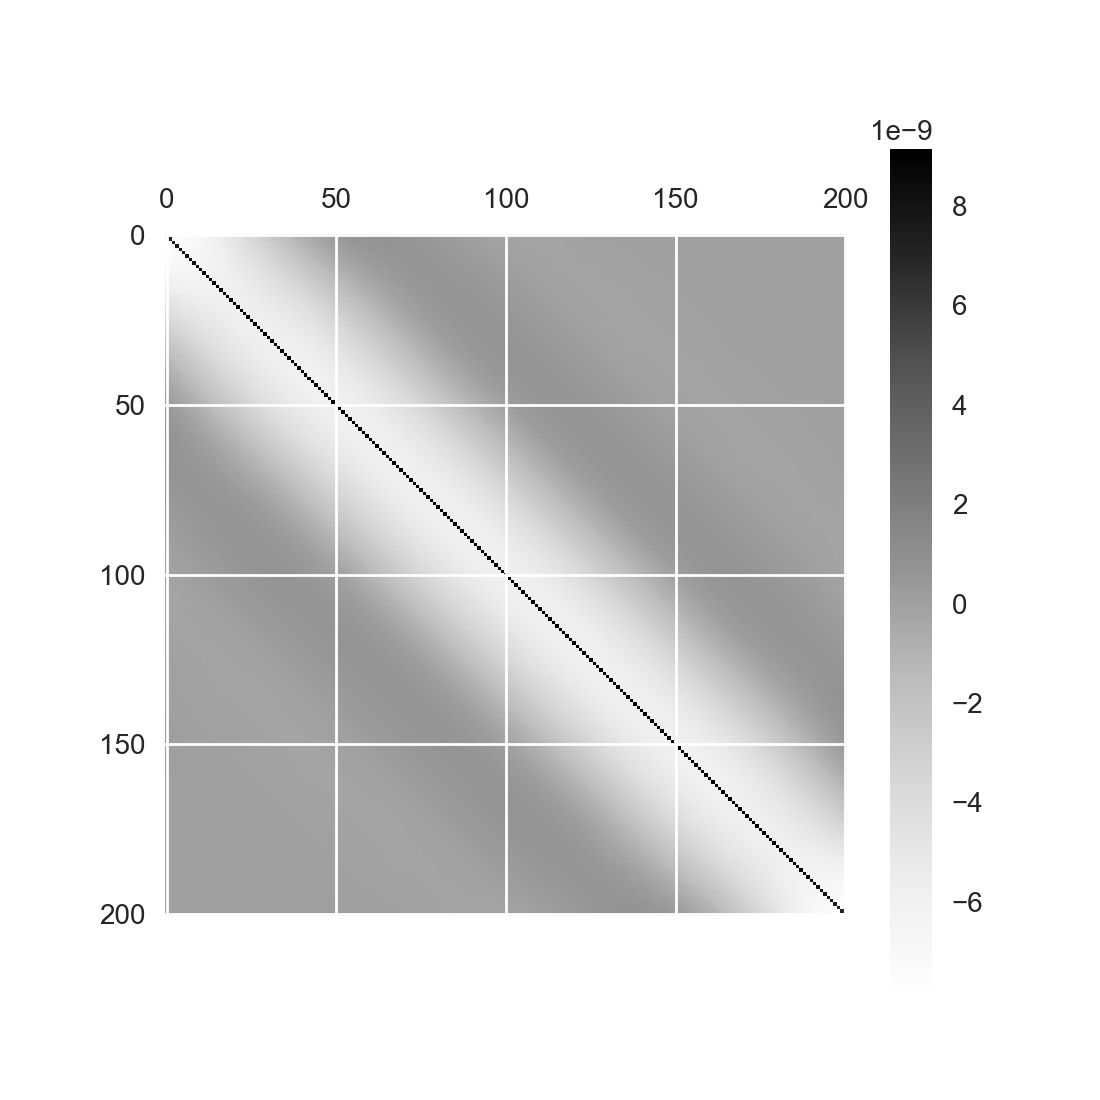

In [42]:
plt.matshow(Sigma1_mat - cov1_gp)
plt.colorbar()
plt.show()

In [116]:
ker1 = gpr.SquareExp(lengthscale=hp1['l2']**0.5,tau=hp1['tau2']**0.5)+gpr.WhiteNoise(C=hp1['sigma2'])

In [117]:
y1_gp2 = gpr.GaussianProcessRegressor(ker1)
y1_gp2.fit(T_obs,y_noisy[0])

In [118]:
mu, Sigma = y1_gp2.predict(T_sur,ret_cov=True)
Sigma = .5*(Sigma+Sigma.T)

In [119]:
la.norm(Sigma-Sigma1_mat)

2.602613148899589e-07

In [87]:
e1,v1 = la.eig(Sigma)
e1,v1 = e1.real,v1.real
W1 = np.real(np.diag(np.sqrt(1/e1))@(v1.T))

In [60]:
la.norm(W1-W1_mat)

65.43519587330937

In [90]:
la.norm(Sigma1_mat@v1 - v1@np.diag(e1))

2.601667590027988e-07

In [91]:
la.norm(Sigma@V1 - V1@D1)

2.6026131491262636e-07

In [84]:
v1

array([[-0.00900237+0.j,  0.0212183 +0.j,  0.04086684+0.j, ...,
         0.00450216+0.j,  0.03698627+0.j,  0.05129077+0.j],
       [-0.00987507+0.j,  0.02301716+0.j,  0.04350831+0.j, ...,
        -0.02449501+0.j, -0.09886238+0.j, -0.07429179+0.j],
       [-0.01077441+0.j,  0.02485413+0.j,  0.04615837+0.j, ...,
         0.03088646+0.j,  0.04458981+0.j, -0.09454558+0.j],
       ...,
       [-0.01077441+0.j, -0.02485413+0.j,  0.04615837+0.j, ...,
         0.00175738+0.j,  0.05210978+0.j,  0.02048378+0.j],
       [-0.00987507+0.j, -0.02301716+0.j,  0.04350831+0.j, ...,
         0.02513552+0.j, -0.02387302+0.j,  0.04061358+0.j],
       [-0.00900237+0.j, -0.0212183 +0.j,  0.04086684+0.j, ...,
        -0.01049987+0.j,  0.00266719+0.j, -0.02286577+0.j]])

In [67]:
Sigma1_mat@V1-V1@D1

array([[ 3.14059829e-02, -2.25781872e-02,  1.78960639e-03, ...,
        -4.29919847e-02, -2.55940891e-02, -1.14320143e-02],
       [-9.54434490e-02,  4.51697019e-02, -1.39443214e-02, ...,
        -4.57708167e-02, -2.77639258e-02, -1.25402434e-02],
       [ 1.94859326e-02,  7.24107312e-02,  3.02921108e-02, ...,
        -4.85586750e-02, -2.99797362e-02, -1.36823017e-02],
       ...,
       [ 7.26790459e-02,  1.66602493e-01,  1.85223328e-01, ...,
        -4.85586750e-02,  2.99797362e-02, -1.36823017e-02],
       [-3.39786874e-02, -4.00152596e-02, -9.21336900e-02, ...,
        -4.57708167e-02,  2.77639258e-02, -1.25402434e-02],
       [-1.60014744e-18, -6.86210740e-21, -1.43306032e-18, ...,
        -4.29919847e-02,  2.55940891e-02, -1.14320143e-02]])

In [68]:
la.eig(Sigma1_mat)

(array([1.98047303+0.00000000e+00j, 1.92666572+0.00000000e+00j,
        1.79781121+0.00000000e+00j, 1.53901383+0.00000000e+00j,
        1.14731798+0.00000000e+00j, 0.73153395+0.00000000e+00j,
        0.40134419+0.00000000e+00j, 0.20490802+0.00000000e+00j,
        0.12296159+0.00000000e+00j, 0.09787234+0.00000000e+00j,
        0.09162146+0.00000000e+00j, 0.09026063+0.00000000e+00j,
        0.08999283+0.00000000e+00j, 0.08994442+0.00000000e+00j,
        0.08993634+0.00000000e+00j, 0.08993508+0.00000000e+00j,
        0.0899349 +0.00000000e+00j, 0.08993487+0.00000000e+00j,
        0.08993487+0.00000000e+00j, 0.08993487+0.00000000e+00j,
        0.08993487+0.00000000e+00j, 0.08993487+0.00000000e+00j,
        0.08993487+0.00000000e+00j, 0.08993487+0.00000000e+00j,
        0.08993487+0.00000000e+00j, 0.08993487+0.00000000e+00j,
        0.08993487+0.00000000e+00j, 0.08993487+0.00000000e+00j,
        0.08993487+0.00000000e+00j, 0.08993487+3.23608468e-17j,
        0.08993487-3.23608468e-17j, 0.08